<a href="https://colab.research.google.com/github/spanman888/DSC672_Teacher_Salary/blob/master/Capstone_Teacher_Salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np

# In order to download files to local file system
from google.colab import drive
drive.mount('drive')



Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
#Load from GitHub
url2003 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2003_tsr_public_dataset.csv'
url2004 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2004_tsr_public_dataset.csv'
url2005 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2005_tsr_public_dataset.csv'
url2006 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2006_tsr_public_dataset.csv'
url2007 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2007_tsr_public_dataset.csv'
url2008 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2008_tsr_public_dataset.csv'
url2009 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2009_tsr_public_dataset.csv'
url2010 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2010_tsr_public_dataset.csv'
url2011 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2011_tsr_public_dataset.csv'
url2012 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2012-tsr-public-dataset.csv'

#Load inflation data from GitHub
inflation_GitHub = 'https://github.com/spanman888/DSC672_Teacher_Salary/blob/master/DSC672_Data/CPIAUCNS_2003_2019.xls?raw=true'

In [3]:
df = pd.concat(map(pd.read_csv, [url2003, url2004,url2005,url2006,url2007,url2008,url2009,url2010,url2011,url2012]))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,7,8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.count()

fy                     1624887
rcdt                   1624887
dst_name               1624846
dst_addr               1624846
dst_city               1624846
dst_st                 1624846
dst_zip                1624846
dst_zip_plus4          1624846
sch_num                1624887
sch_name               1624866
sch_addr               1503783
sch_city               1503783
sch_st                 1503783
sch_zip                1503783
sch_zip_plus4          1503783
last_name              1624887
first_name             1624887
mid_init               1624887
gender                 1624887
race_ethnicity_cd      1624559
race_ethnicity_desc    1624468
tsr_status_cd          1624887
tsr_status_desc        1624887
location_cd            1624878
location_desc          1624833
emply_type             1624887
emply_desc             1624665
salary                 1624887
months_employed        1624887
pct_emp                1624887
                        ...   
dist_exp               1624887
state_ex

In [0]:
#moving salary to first column
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('salary')))
cols

df = df.reindex(columns= cols)

In [0]:
#Create column with first three of zip
df['first_3'] = df['dst_zip'].astype(str).str[0:3]

#Assign suburb zips to a list
suburb = ['600','601','603','604','605','607','608']

#Create new Zip_Type column and assign based on first three of zip
df['Zip_Type'] = np.where(df["first_3"].isin(suburb), "Suburb", "Other")
df['Zip_Type'] = np.where(df["first_3"] == '606', 'Chicago', df["Zip_Type"])

In [7]:
#Loading inflation data
inflation = pd.read_excel(inflation_GitHub, sheet_name='FRED Graph')

#Indexing inflation to latest value in data
inflation['CPI_Multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']

#Breaking out year and date columns
inflation['year'] = inflation['observation_date'].dt.year
inflation['month'] = inflation['observation_date'].dt.month

#Only keeping Jan 1 values for each year
inflation = inflation[inflation['month'] == 1]

#Only keeping CPI Multiplier and year
inflation = inflation.drop(['observation_date','CPIAUCNS', 'month'], axis=1)

#Matching column names with data
inflation.columns = ['CPI_Multiplier', 'fy']

# merge dataframe
df = pd.merge(df, inflation, how='left', on='fy')

#Inflation adjusting salary by multiplying salary by CPI Multiplier
df['CPIAdjSalary'] = df['salary'] * df['CPI_Multiplier'] 


/usr/local/lib/python3.6/dist-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [0]:
#Adding Inflation Adjusted Salary per Month
df['AdjSalMonth'] = df['CPIAdjSalary'] / df['months_employed'] 

#Adding Non-Inflation Adjusted Salary per Month
df['SalMonth'] = df['salary'] / df['months_employed'] 

In [9]:
#moving CPIAdjSalary to first column
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('CPIAdjSalary')))
cols

df = df.reindex(columns= cols)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_addr,dst_city,dst_st,dst_zip,dst_zip_plus4,...,assignment_6,assign6_desc,assignment_7,assign7_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,980 Park Ave,Genoa,IL,60135.0,1423,...,NaN,NaN,NaN,NaN,0.0,601,Suburb,1.39902,4029.489540,2880.222222
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,1235 Oak St,Winnetka,IL,60093.0,2168,...,NaN,NaN,NaN,NaN,0.0,600,Suburb,1.39902,12889.019160,9212.888889
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,310 James St,Barrington,IL,60010.0,3329,...,NaN,NaN,NaN,NaN,0.0,600,Suburb,1.39902,13310.454613,9514.125000
3,78017.979429,55766.15,2003,31045046022,SD U-46,355 E Chicago St,Elgin,IL,60120.0,6543,...,NaN,NaN,NaN,NaN,0.0,601,Suburb,1.39902,8668.664381,6196.238889
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,5500 S Grant St,Hinsdale,IL,60521.0,4578,...,NaN,NaN,NaN,NaN,0.0,605,Suburb,1.39902,10681.660375,7635.100000


In [10]:
#removing assignment_4 thru assign7_desc variables; tsr_status variables; state variables; teacher names columns

df = df.drop(['assignment_4', 'assign4_desc', 'assignment_5','assign5_desc','assignment_6','assign6_desc','assignment_7','assign7_desc', 'dst_st', 'sch_st','tsr_status_cd', 'tsr_status_desc', 'mid_init','last_name','first_name'], axis=1)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_addr,dst_city,dst_zip,dst_zip_plus4,sch_num,...,assignment_2,assign2_desc,assignment_3,assign3_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,980 Park Ave,Genoa,60135.0,1423,1003,...,0.0,NaN,0.0,NaN,0.0,601,Suburb,1.39902,4029.489540,2880.222222
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,1235 Oak St,Winnetka,60093.0,2168,1005,...,0.0,NaN,0.0,NaN,0.0,600,Suburb,1.39902,12889.019160,9212.888889
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,310 James St,Barrington,60010.0,3329,0004,...,0.0,NaN,0.0,NaN,0.0,600,Suburb,1.39902,13310.454613,9514.125000
3,78017.979429,55766.15,2003,31045046022,SD U-46,355 E Chicago St,Elgin,60120.0,6543,1003,...,0.0,NaN,0.0,NaN,0.0,601,Suburb,1.39902,8668.664381,6196.238889
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,5500 S Grant St,Hinsdale,60521.0,4578,0002,...,0.0,NaN,0.0,NaN,0.0,605,Suburb,1.39902,10681.660375,7635.100000


In [11]:
#removing school address, district address
df = df.drop(['sch_addr','dst_addr', 'high_grd_desc','low_grd_desc'],axis=1)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,dst_zip_plus4,sch_num,sch_name,...,assignment_2,assign2_desc,assignment_3,assign3_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1423,1003,Genoa-Kingston Middle School,...,0.0,NaN,0.0,NaN,0.0,601,Suburb,1.39902,4029.489540,2880.222222
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,2168,1005,Carleton W Washburne School,...,0.0,NaN,0.0,NaN,0.0,600,Suburb,1.39902,12889.019160,9212.888889
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,3329,0004,Barrington High School,...,0.0,NaN,0.0,NaN,0.0,600,Suburb,1.39902,13310.454613,9514.125000
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,6543,1003,Abbott Middle School,...,0.0,NaN,0.0,NaN,0.0,601,Suburb,1.39902,8668.664381,6196.238889
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,4578,0002,Hinsdale South High School,...,0.0,NaN,0.0,NaN,0.0,605,Suburb,1.39902,10681.660375,7635.100000


In [12]:
#removing info on specific bachelor/advanced degree schools
df = df.drop(['bacc_coll','bacc_coll_desc','adv_coll','adv_coll_desc'],axis=1)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,dst_zip_plus4,sch_num,sch_name,...,assignment_2,assign2_desc,assignment_3,assign3_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1423,1003,Genoa-Kingston Middle School,...,0.0,NaN,0.0,NaN,0.0,601,Suburb,1.39902,4029.489540,2880.222222
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,2168,1005,Carleton W Washburne School,...,0.0,NaN,0.0,NaN,0.0,600,Suburb,1.39902,12889.019160,9212.888889
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,3329,0004,Barrington High School,...,0.0,NaN,0.0,NaN,0.0,600,Suburb,1.39902,13310.454613,9514.125000
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,6543,1003,Abbott Middle School,...,0.0,NaN,0.0,NaN,0.0,601,Suburb,1.39902,8668.664381,6196.238889
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,4578,0002,Hinsdale South High School,...,0.0,NaN,0.0,NaN,0.0,605,Suburb,1.39902,10681.660375,7635.100000


In [13]:
#creating variables denoting 2 or 3 assignments
def assign(x):
    if x > 0:
      return 1
    else:
      return 0

df["multi_assign_2"] = df["assignment_2"].apply(assign)
df["multi_assign_3"] = df["assignment_3"].apply(assign)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,dst_zip_plus4,sch_num,sch_name,...,assignment_3,assign3_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1423,1003,Genoa-Kingston Middle School,...,0.0,NaN,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,2168,1005,Carleton W Washburne School,...,0.0,NaN,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,3329,0004,Barrington High School,...,0.0,NaN,0.0,600,Suburb,1.39902,13310.454613,9514.125000,0,0
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,6543,1003,Abbott Middle School,...,0.0,NaN,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,4578,0002,Hinsdale South High School,...,0.0,NaN,0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0


In [14]:
#removing assignment_2 and assignment_3 variables
df = df.drop(['assignment_2','assign2_desc','assignment_3','assign3_desc'],axis=1)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,dst_zip_plus4,sch_num,sch_name,...,assignment_1,assign1_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1423,1003,Genoa-Kingston Middle School,...,21,Other Math,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,2168,1005,Carleton W Washburne School,...,47,Other Subject or Prog Areas Not Listed,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,3329,0004,Barrington High School,...,223,Social Worker,0.0,600,Suburb,1.39902,13310.454613,9514.125000,0,0
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,6543,1003,Abbott Middle School,...,140,Other Family & Consumer Sciences Occupations,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,4578,0002,Hinsdale South High School,...,1,English (Grades 9-12 Only),0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0


In [15]:
#removing pct_emp varialbe - same values as fte; also removing emply_type
df = df.drop(['pct_emp', 'emply_type'],axis=1)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,dst_zip_plus4,sch_num,sch_name,...,assignment_1,assign1_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1423,1003,Genoa-Kingston Middle School,...,21,Other Math,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,2168,1005,Carleton W Washburne School,...,47,Other Subject or Prog Areas Not Listed,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,3329,0004,Barrington High School,...,223,Social Worker,0.0,600,Suburb,1.39902,13310.454613,9514.125000,0,0
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,6543,1003,Abbott Middle School,...,140,Other Family & Consumer Sciences Occupations,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,4578,0002,Hinsdale South High School,...,1,English (Grades 9-12 Only),0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0


In [16]:
#removing zip code + 4 features variable - postal route not useful for analysis
df = df.drop(['dst_zip_plus4'],axis=1)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,sch_num,sch_name,sch_city,...,assignment_1,assign1_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1003,Genoa-Kingston Middle School,Genoa,...,21,Other Math,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,1005,Carleton W Washburne School,Winnetka,...,47,Other Subject or Prog Areas Not Listed,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,0004,Barrington High School,Barrington,...,223,Social Worker,0.0,600,Suburb,1.39902,13310.454613,9514.125000,0,0
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,1003,Abbott Middle School,Elgin,...,140,Other Family & Consumer Sciences Occupations,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,0002,Hinsdale South High School,Darien,...,1,English (Grades 9-12 Only),0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0


In [17]:
#dropping all rows with NA values
df = df.dropna()
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,sch_num,sch_name,sch_city,...,assignment_1,assign1_desc,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1003,Genoa-Kingston Middle School,Genoa,...,21,Other Math,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,1005,Carleton W Washburne School,Winnetka,...,47,Other Subject or Prog Areas Not Listed,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,0004,Barrington High School,Barrington,...,223,Social Worker,0.0,600,Suburb,1.39902,13310.454613,9514.125000,0,0
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,1003,Abbott Middle School,Elgin,...,140,Other Family & Consumer Sciences Occupations,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,0002,Hinsdale South High School,Darien,...,1,English (Grades 9-12 Only),0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0


In [18]:
#row count
df.shape

(1501721, 39)

In [0]:
#Calculate Z-Scores for Adjusted Salary per Month and add as a column
from scipy import stats
df['z_score'] = np.abs(stats.zscore(df['AdjSalMonth']))

In [0]:
#Filter only where z_score of adjusted salary per month is less than 3 (standard deviations)
df = df[df["z_score"] < 3]

In [21]:
#We removed 9385 records
df.shape

(1492336, 40)

In [22]:
print(df['gender'].value_counts())
print(df['high_degre_desc'].value_counts())
print(df['race_ethnicity_desc'].value_counts())
print(df['race_ethnicity_cd'].value_counts())
print(df['location_cd'].value_counts())
print(df['location_desc'].value_counts())
print(df['Zip_Type'].value_counts())

F    1143225
M     349110
           1
Name: gender, dtype: int64
Masters                                   851747
Baccalaureate                             622104
Doctorate                                  11970
None                                        3526
C.A.S., Specialist, 6 Year Certificate      2645
Registered Nurse                             344
Name: high_degre_desc, dtype: int64
White, Non-Hispanic                          1015724
White                                         251214
Black, Non-Hispanic                           107886
Hispanic                                       52602
Black or African American                      22400
Hispanic or Latino                             15025
Asian or Pacific Islander                      13484
Unknown                                         5527
Asian                                           3586
Two or More Races                               2256
American Indian or Alaskan Native               1895
American Indian or Al

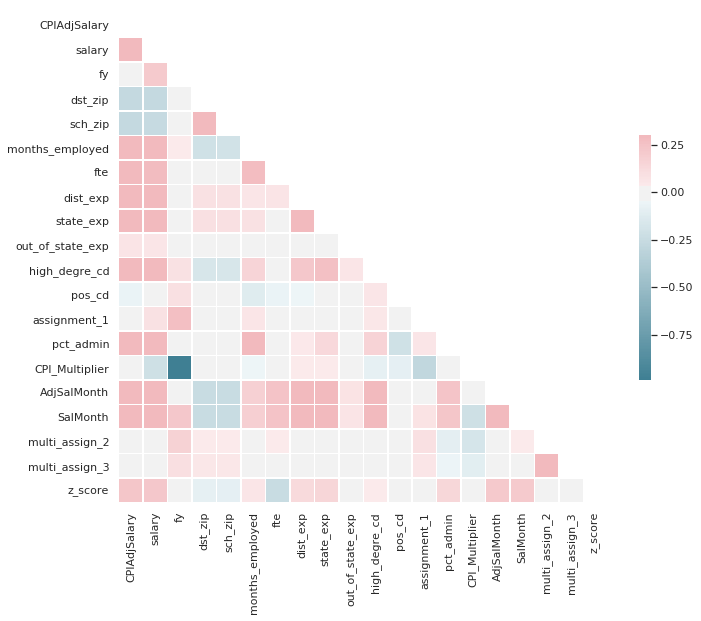

In [23]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
#dropping row where gender is ' '
df = df.drop(df[df.gender==' '].index)
df.shape

(1492335, 40)

In [0]:
print(df['gender'].value_counts())

In [47]:
#grouping ethnicities
def eth_assign(x):
    if x == 'White' or x == 'White, Non-Hispanic':
      return 'White'
    elif x == 'Black' or x == 'Black, Non-Hispanic' or x == 'Black or African American':
      return 'Black'
    elif x == 'Hispanic' or x == 'Hispanic or Latino':
      return 'Hispanic'
    elif x == 'Asian or Pacific Islander' or x == 'Native Hawaiian or Other Pacific Islander' or x == 'Asian':
      return 'Asian or Pacific Islander'
    elif x == 'American Indian or Alaska Native' or x == 'American Indian or Alaskan Native':
      return 'American Indian or Alaska Native'
    else:
      return 'Unknown'
       

df["eth_groups"] = df["race_ethnicity_desc"].apply(eth_assign)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,sch_num,sch_name,sch_city,...,pct_admin,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score,eth_groups
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1003,Genoa-Kingston Middle School,Genoa,...,0.0,601,Suburb,1.39902,4029.489540,2880.222222,0,0,1.396198,White
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,1005,Carleton W Washburne School,Winnetka,...,0.0,600,Suburb,1.39902,12889.019160,9212.888889,0,0,1.772691,White
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,0004,Barrington High School,Barrington,...,0.0,600,Suburb,1.39902,13310.454613,9514.125000,0,0,1.923431,White
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,1003,Abbott Middle School,Elgin,...,0.0,601,Suburb,1.39902,8668.664381,6196.238889,0,0,0.263149,White
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,0002,Hinsdale South High School,Darien,...,0.0,605,Suburb,1.39902,10681.660375,7635.100000,0,0,0.983160,White


In [48]:
#grouping education level
def edu_assign(x):
    if x == 'Masters':
      return 'Masters'
    elif x == 'Baccalaureate':
      return 'Bachelors'
    elif x == 'Doctorate':
      return 'Doctorate'
    elif x == 'None':
      return 'None'
    else:
      return 'Other'
       

df["edu_groups"] = df["high_degre_desc"].apply(edu_assign)
df.head(5)

,CPIAdjSalary,salary,fy,rcdt,dst_name,dst_city,dst_zip,sch_num,sch_name,sch_city,...,first_3,Zip_Type,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score,eth_groups,edu_groups
0,36265.405856,25922.00,2003,16019424026,Genoa Kingston CUSD 424,Genoa,60135.0,1003,Genoa-Kingston Middle School,Genoa,...,601,Suburb,1.39902,4029.489540,2880.222222,0,0,1.396198,White,Bachelors
1,116001.172438,82916.00,2003,05016036002,Winnetka SD 36,Winnetka,60093.0,1005,Carleton W Washburne School,Winnetka,...,600,Suburb,1.39902,12889.019160,9212.888889,0,0,1.772691,White,Masters
2,133104.546134,95141.25,2003,34049220026,Barrington CUSD 220,Barrington,60010.0,0004,Barrington High School,Barrington,...,600,Suburb,1.39902,13310.454613,9514.125000,0,0,1.923431,White,Masters
3,78017.979429,55766.15,2003,31045046022,SD U-46,Elgin,60120.0,1003,Abbott Middle School,Elgin,...,601,Suburb,1.39902,8668.664381,6196.238889,0,0,0.263149,White,Masters
4,106816.603753,76351.00,2003,19022086017,Hinsdale Twp HSD 86,Hinsdale,60521.0,0002,Hinsdale South High School,Darien,...,605,Suburb,1.39902,10681.660375,7635.100000,0,0,0.983160,White,Masters


In [49]:
print(df['eth_groups'].value_counts())
print(df['edu_groups'].value_counts())

White                               1266938
Black                                130286
Hispanic                              67627
Asian or Pacific Islander             17325
Unknown                                7782
American Indian or Alaska Native       2377
Name: eth_groups, dtype: int64
Masters      851747
Bachelors    622104
Doctorate     11970
None           3525
Other          2989
Name: edu_groups, dtype: int64


In [0]:
#deleting original ethnicity, education, and location_cd columns - no longer needed for analysis
df = df.drop(['high_degre_cd', 'high_degre_desc', 'race_ethnicity_cd', 'race_ethnicity_desc', 'location_cd'],axis=1)


In [51]:
df.count()

CPIAdjSalary        1492335
salary              1492335
fy                  1492335
rcdt                1492335
dst_name            1492335
dst_city            1492335
dst_zip             1492335
sch_num             1492335
sch_name            1492335
sch_city            1492335
sch_zip             1492335
sch_zip_plus4       1492335
gender              1492335
location_desc       1492335
emply_desc          1492335
months_employed     1492335
fte                 1492335
dist_exp            1492335
state_exp           1492335
out_of_state_exp    1492335
pos_cd              1492335
pos_desc            1492335
low_grade           1492335
high_grade          1492335
assignment_1        1492335
assign1_desc        1492335
pct_admin           1492335
first_3             1492335
Zip_Type            1492335
CPI_Multiplier      1492335
AdjSalMonth         1492335
SalMonth            1492335
multi_assign_2      1492335
multi_assign_3      1492335
z_score             1492335
eth_groups          

In [0]:
# Command to download the CSV file to your Google Drive. File is data.csv
df.to_csv('data.csv')
!cp data.csv drive/My\ Drive/

In [0]:
score06 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_06_dist.xls?raw=true'
score07 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_07_dist.xls?raw=true'
score08 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_08_dist.xls?raw=true'
score09 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_09_dist.xls?raw=true'
score10 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_10_dist.xls?raw=true'
score11 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_11_dist.xlsx?raw=true'
score12 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_12_dist.xlsx?raw=true'

In [0]:
# merge test score datasets 
scores = pd.concat(map(pd.read_excel, [score06, score07, score08, score09, score10, score11, score12]))

In [55]:
scores.head(5)

,RCDTS,rcdt,County,Dist #,District Name/ School Name,City,3rd Grade Reading,3rd Grade Math,4th Grade Reading,4th Grade Math,...,7th Grade Math,8th Grade Reading,8th Grade Math,11th Grade Reading,11th Grade Math,ISAT,PSAE,ACT Score,Enrollment,Year
0,010010010260000,01001001026,ADAMS,0010,PAYSON CUSD 1,PAYSON,70.6,91.2,85.1,97.9,...,69.0,78.7,82.0,65.9,46.3,82.2,54.5,18.3,599,2006
1,010010020260000,01001002026,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,86.0,100.0,66.0,83.0,...,83.3,78.0,92.7,84.2,71.1,80.8,73.7,19.5,626,2006
2,010010030260000,01001003026,ADAMS,0030,CENTRAL CUSD 3,CAMP POINT,69.2,84.6,68.3,81.3,...,86.8,84.3,85.3,52.8,46.1,81.0,48.3,19.8,1053,2006
3,010010040260000,01001004026,ADAMS,0040,CUSD 4,MENDON,63.0,87.0,83.0,88.7,...,73.5,62.3,75.4,66.0,64.0,78.7,62.0,21.4,786,2006
4,010011720220000,01001172022,ADAMS,1720,QUINCY SD 172,QUINCY,75.9,88.1,76.1,87.7,...,81.9,78.0,76.5,50.3,52.7,80.4,49.2,19.7,6484,2006


In [0]:
# drop RCDTS, ISAT, PSAE, and ACT columns
scores = scores.drop(['RCDTS', 'ISAT', 'PSAE', 'ACT Score'],axis=1)

In [57]:
scores.shape

(6082, 21)

In [58]:
scores.count()

rcdt                          6082
County                        6082
Dist #                        6082
District Name/ School Name    6082
City                          6082
3rd Grade Reading             5192
3rd Grade Math                5193
4th Grade Reading             5204
4th Grade Math                5204
5th Grade Reading             5213
5th Grade Math                5214
6th Grade Reading             5213
6th Grade Math                5209
7th Grade Reading             5205
7th Grade Math                5203
8th Grade Reading             5208
8th Grade Math                5208
11th Grade Reading            3363
11th Grade Math               3363
Enrollment                    6082
Year                          6082
dtype: int64

In [59]:
# add columns with average reading and math score 
scores['Reading AVG'] = scores[['3rd Grade Reading', '4th Grade Reading', '5th Grade Reading', '6th Grade Reading', '7th Grade Reading', 
                                '8th Grade Reading', '11th Grade Reading']].mean(axis=1)
scores['Math AVG'] = scores[['3rd Grade Math', '4th Grade Math', '5th Grade Math', '6th Grade Math', '7th Grade Math', 
                                '8th Grade Math', '11th Grade Math']].mean(axis=1)
pd.set_option("display.max_columns", 35)
scores.head(5)

,rcdt,County,Dist #,District Name/ School Name,City,3rd Grade Reading,3rd Grade Math,4th Grade Reading,4th Grade Math,5th Grade Reading,5th Grade Math,6th Grade Reading,6th Grade Math,7th Grade Reading,7th Grade Math,8th Grade Reading,8th Grade Math,11th Grade Reading,11th Grade Math,Enrollment,Year,Reading AVG,Math AVG
0,01001001026,ADAMS,0010,PAYSON CUSD 1,PAYSON,70.6,91.2,85.1,97.9,82.5,90.0,78.8,88.5,71.4,69.0,78.7,82.0,65.9,46.3,599,2006,76.142857,80.700000
1,01001002026,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,86.0,100.0,66.0,83.0,68.1,80.9,73.2,90.2,79.2,83.3,78.0,92.7,84.2,71.1,626,2006,76.385714,85.885714
2,01001003026,ADAMS,0030,CENTRAL CUSD 3,CAMP POINT,69.2,84.6,68.3,81.3,75.0,85.9,68.4,88.3,75.0,86.8,84.3,85.3,52.8,46.1,1053,2006,70.428571,79.757143
3,01001004026,ADAMS,0040,CUSD 4,MENDON,63.0,87.0,83.0,88.7,83.3,94.4,72.9,93.8,65.3,73.5,62.3,75.4,66.0,64.0,786,2006,70.828571,82.400000
4,01001172022,ADAMS,1720,QUINCY SD 172,QUINCY,75.9,88.1,76.1,87.7,76.5,81.8,76.0,85.4,73.2,81.9,78.0,76.5,50.3,52.7,6484,2006,72.285714,79.157143


In [60]:
# drop grade level reading and math columns 
scores = scores.drop(['3rd Grade Reading', '4th Grade Reading', '5th Grade Reading', '6th Grade Reading', '7th Grade Reading', 
                      '8th Grade Reading', '11th Grade Reading', '3rd Grade Math', '4th Grade Math', '5th Grade Math', '6th Grade Math',
                      '7th Grade Math', '8th Grade Math', '11th Grade Math'],axis=1)
scores = scores.rename({'District Name/ School Name':'District Name'}, axis=1)
scores = scores.rename({'County ':'County'}, axis=1)
scores.head(5)

,rcdt,County,Dist #,District Name,City,Enrollment,Year,Reading AVG,Math AVG
0,01001001026,ADAMS,0010,PAYSON CUSD 1,PAYSON,599,2006,76.142857,80.700000
1,01001002026,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,626,2006,76.385714,85.885714
2,01001003026,ADAMS,0030,CENTRAL CUSD 3,CAMP POINT,1053,2006,70.428571,79.757143
3,01001004026,ADAMS,0040,CUSD 4,MENDON,786,2006,70.828571,82.400000
4,01001172022,ADAMS,1720,QUINCY SD 172,QUINCY,6484,2006,72.285714,79.157143


In [61]:
# capitalize County, District Name, and City values 
scores['County'] = scores['County'].str.upper()
scores['District Name'] = scores['District Name'].str.upper()
scores['City'] = scores['City'].str.upper()
scores.head(5)

,rcdt,County,Dist #,District Name,City,Enrollment,Year,Reading AVG,Math AVG
0,01001001026,ADAMS,0010,PAYSON CUSD 1,PAYSON,599,2006,76.142857,80.700000
1,01001002026,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,626,2006,76.385714,85.885714
2,01001003026,ADAMS,0030,CENTRAL CUSD 3,CAMP POINT,1053,2006,70.428571,79.757143
3,01001004026,ADAMS,0040,CUSD 4,MENDON,786,2006,70.828571,82.400000
4,01001172022,ADAMS,1720,QUINCY SD 172,QUINCY,6484,2006,72.285714,79.157143


In [0]:
# rename some counties so that they match
scores['County'].replace({'JO DAVIESS':'JODAVIESS', 'LA SALLE':'LASALLE', 'SAINT CLAIR':'ST. CLAIR'},inplace=True, regex=True)

In [63]:
scores.count()

rcdt             6082
County           6082
Dist #           6082
District Name    6082
City             6082
Enrollment       6082
Year             6082
Reading AVG      6029
Math AVG         6029
dtype: int64

In [64]:
# drop rows with no scores 
scores = scores.dropna()
scores.count()

rcdt             6029
County           6029
Dist #           6029
District Name    6029
City             6029
Enrollment       6029
Year             6029
Reading AVG      6029
Math AVG         6029
dtype: int64

In [65]:
# dataframe of AdjSalMonth, year, and rcdt codes
sal_df = df[['rcdt', 'fy', 'AdjSalMonth']].copy()
sal_df.head(5)


,rcdt,fy,AdjSalMonth
0,16019424026,2003,4029.489540
1,05016036002,2003,12889.019160
2,34049220026,2003,13310.454613
3,31045046022,2003,8668.664381
4,19022086017,2003,10681.660375


In [66]:
# district salary statistics dataframe
dist_sal = pd.DataFrame(sal_df.groupby(['rcdt', 'fy']).describe())
dist_sal.reset_index(inplace=True)
dist_sal.columns = ['rcdt', 'Year', 'AdjSalMonth count', 'AdjSalMonth mean', 'AdjSalMonth std', 'AdjSalMonth min', 'AdjSalMonth 25%', 
                   'AdjSalMonth median', 'AdjSalMonth 75%', 'AdjSalMonth max']
dist_sal.head(5)

,rcdt,Year,AdjSalMonth count,AdjSalMonth mean,AdjSalMonth std,AdjSalMonth min,AdjSalMonth 25%,AdjSalMonth median,AdjSalMonth 75%,AdjSalMonth max
0,15016299025,2012,15303.0,8569.292325,2113.583414,181.805610,7029.428566,8934.331427,10122.323304,16127.646723
1,01001001026,2003,51.0,6224.562218,1150.337947,4430.145655,5213.628925,6325.923951,7130.939698,8346.972084
2,01001001026,2004,47.0,6212.630489,1387.245664,1802.572492,5249.493201,6582.873738,7253.143470,8432.832606
3,01001001026,2005,47.0,6171.237846,1356.094989,3236.431496,5161.929075,6292.776145,7247.044196,8760.014495
4,01001001026,2006,47.0,5964.386253,1424.081385,2728.194087,4714.018487,5814.648197,7176.496919,8396.215003


In [67]:
dist_sal.shape

(10136, 10)

In [68]:
# join dist_sal dataframe with scores dataframe
scores_df = pd.merge(dist_sal, scores, how='inner', on=['rcdt','Year'])
scores_df.head(5)

,rcdt,Year,AdjSalMonth count,AdjSalMonth mean,AdjSalMonth std,AdjSalMonth min,AdjSalMonth 25%,AdjSalMonth median,AdjSalMonth 75%,AdjSalMonth max,County,Dist #,District Name,City,Enrollment,Reading AVG,Math AVG
0,01001001026,2006,47.0,5964.386253,1424.081385,2728.194087,4714.018487,5814.648197,7176.496919,8396.215003,ADAMS,0010,PAYSON CUSD 1,PAYSON,599,76.142857,80.700000
1,01001001026,2007,47.0,6012.027420,1410.220155,3891.773646,4723.731287,5833.619875,7283.188269,8552.166251,ADAMS,0010,PAYSON CUSD 1,PAYSON,583,72.228571,78.514286
2,01001001026,2008,50.0,6005.476387,1533.865579,3862.171813,4688.587570,5632.517492,7219.693003,9607.624483,ADAMS,0010,PAYSON CUSD 1,PAYSON,546,72.814286,77.414286
3,01001001026,2009,49.0,5990.946466,1709.016862,4156.342831,4815.886692,5513.074859,6876.770300,13420.019088,ADAMS,0010,PAYSON CUSD 1,PAYSON,540,79.242857,83.071429
4,01001001026,2010,50.0,5995.794153,1705.942709,4251.409746,4691.086451,5548.137360,6842.522359,13369.539783,ADAMS,0010,PAYSON CUSD 1,PAYSON,541,80.228571,84.671429


In [69]:
scores_df.shape

(5312, 17)

In [70]:
# add column for student to teacher ratio
scores_df['Students/Teacher'] = scores_df['Enrollment']/scores_df['AdjSalMonth count']
scores_df.head(5)

,rcdt,Year,AdjSalMonth count,AdjSalMonth mean,AdjSalMonth std,AdjSalMonth min,AdjSalMonth 25%,AdjSalMonth median,AdjSalMonth 75%,AdjSalMonth max,County,Dist #,District Name,City,Enrollment,Reading AVG,Math AVG,Students/Teacher
0,01001001026,2006,47.0,5964.386253,1424.081385,2728.194087,4714.018487,5814.648197,7176.496919,8396.215003,ADAMS,0010,PAYSON CUSD 1,PAYSON,599,76.142857,80.700000,12.744681
1,01001001026,2007,47.0,6012.027420,1410.220155,3891.773646,4723.731287,5833.619875,7283.188269,8552.166251,ADAMS,0010,PAYSON CUSD 1,PAYSON,583,72.228571,78.514286,12.404255
2,01001001026,2008,50.0,6005.476387,1533.865579,3862.171813,4688.587570,5632.517492,7219.693003,9607.624483,ADAMS,0010,PAYSON CUSD 1,PAYSON,546,72.814286,77.414286,10.920000
3,01001001026,2009,49.0,5990.946466,1709.016862,4156.342831,4815.886692,5513.074859,6876.770300,13420.019088,ADAMS,0010,PAYSON CUSD 1,PAYSON,540,79.242857,83.071429,11.020408
4,01001001026,2010,50.0,5995.794153,1705.942709,4251.409746,4691.086451,5548.137360,6842.522359,13369.539783,ADAMS,0010,PAYSON CUSD 1,PAYSON,541,80.228571,84.671429,10.820000


In [0]:
# Command to download the CSV file to your Google Drive. File is scores.csv
scores_df.to_csv('scores.csv')
!cp scores.csv drive/My\ Drive/